# Tabular Modeling Deep Dive
Tabular modeling takes data in the form of a table (like a spreadsheet or CSV). The objective is to predict the value in one column based on the values in the other columns. In this chapter we will not only look at deep learning but also more general machine learning techniques like random forests, as they can give better results depending on your problem.

We will look at how we should preprocess and clean the data as well as how to interpret the result of our models after training, but first, we will see how we can feed columns that contain categories into a model that expects numbers by using embeddings.

Modern machine learning can be distilled down to a couple of key techniques that are widely applicable. Recent studies have shown that the vast majority of datasets can be best modeled with just two methods:

1) Ensembles of decision trees (i.e., random forests and gradient boosting machines), mainly for structured data (such as you might find in a database table at most companies)


2) Multilayered neural networks learned with SGD (i.e., shallow and/or deep learning), mainly for unstructured data (such as audio, images, and natural language)

Although deep learning is nearly always clearly superior for unstructured data, these two approaches tend to give quite similar results for many kinds of structured data. But ensembles of decision trees tend to train faster, are often easier to interpret, do not require special GPU hardware for inference at scale, and often require less hyperparameter tuning. They have also been popular for quite a lot longer than deep learning, so there is a more mature ecosystem of tooling and documentation around them.

Most importantly, the critical step of interpreting a model of tabular data is significantly easier for decision tree ensembles. There are tools and methods for answering the pertinent questions, like: Which columns in the dataset were the most important for your predictions? How are they related to the dependent variable? How do they interact with each other? And which particular features were most important for some particular observation?

Therefore, ensembles of decision trees are our first approach for analyzing a new tabular dataset.

# The Dataset
The dataset (https://www.kaggle.com/c/bluebook-for-bulldozers/data) we use in this chapter is from the Blue Book for Bulldozers Kaggle competition, which has the following description: "The goal of the contest is to predict the sale price of a particular piece of heavy equipment at auction based on its usage, equipment type, and configuration. The data is sourced from auction result postings and includes information on usage and equipment configurations."


This is a very common type of dataset and prediction problem, similar to what you may see in your project or workplace. The dataset is available for download on Kaggle, a website that hosts data science competitions.

#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz

In [1]:
import fastbook

In [2]:
fastbook.setup_book()

In [3]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [4]:
creds ='{"username":"naimcivan","key":"36c2d0e4d72f497775fb19831841cd78"}'

In [5]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [6]:
path = URLs.path('bluebook')
path

Path('C:/Users/Naim Cavin/.fastai/archive/bluebook')

In [7]:
path

Path('C:/Users/Naim Cavin/.fastai/archive/bluebook')

In [8]:

#hide
Path.BASE_PATH = path

In [9]:
if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')

path.ls(file_type='text')

(#0) []

In [10]:
!kaggle competitions download -c bluebook-for-bulldozers

bluebook-for-bulldozers.zip: Skipping, found more recently modified local copy (use --force to force download)


# Look at the Data
Kaggle provides information about some of the fields of our dataset. The Data explains that the key fields in train.csv are:

SalesID:: The unique identifier of the sale.
MachineID:: The unique identifier of a machine. A machine can be sold multiple times.
saleprice:: What the machine sold for at auction (only provided in train.csv).
saledate:: The date of the sale.

In [11]:
df = pd.read_csv('TrainAndValid.csv', low_memory=False)


In [12]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

That's a lot of columns for us to look at! Try looking through the dataset to get a sense of what kind of information is in each one. We'll shortly see how to "zero in" on the most interesting bits.

At this point, a good next step is to handle ordinal columns. This refers to columns containing strings or similar, but where those strings have a natural ordering. For instance, here are the levels of ProductSize:

In [13]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

We can tell Pandas about a suitable ordering of these levels like so:

In [14]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'


In [15]:
df['ProductSize'].dtype

dtype('O')

In [16]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

The most important data column is the dependent variable—that is, the one we want to predict. Recall that a model's metric is a function that reflects how good the predictions are. It's important to note what metric is being used for a project. Generally, selecting the metric is an important part of the project setup. In many cases, choosing a good metric will require more than just selecting a variable that already exists. It is more like a design process. You should think carefully about which metric, or set of metrics, actually measures the notion of model quality that matters to you. If no variable represents that metric, you should see if you can build the metric from the variables that are available.

However, in this case Kaggle tells us what metric to use: root mean squared log error (RMSLE) between the actual and predicted auction prices. We need do only a small amount of processing to use this: we take the log of the prices, so that rmse of that value will give us what we ultimately need:

In [17]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

# Handling Dates
The first piece of data preparation we need to do is to enrich our representation of dates. The fundamental basis of the decision tree that we just described is bisection— dividing a group into two. We look at the ordinal variables and divide up the dataset based on whether the variable's value is greater (or lower) than a threshold, and we look at the categorical variables and divide up the dataset based on whether the variable's level is a particular level. So this algorithm has a way of dividing up the dataset based on both ordinal and categorical data.

But how does this apply to a common data type, the date? You might want to treat a date as an ordinal value, because it is meaningful to say that one date is greater than another. However, dates are a bit different from most ordinal values in that some dates are qualitatively different from others in a way that that is often relevant to the systems we are modeling.

In order to help our algorithm handle dates intelligently, we'd like our model to know more than whether a date is more recent or less recent than another. We might want our model to make decisions based on that date's day of the week, on whether a day is a holiday, on what month it is in, and so forth. To do this, we replace every date column with a set of date metadata columns, such as holiday, day of week, and month. These columns provide categorical data that we suspect will be useful.

In [18]:
df = add_datepart(df, 'saledate')  

# Uploading the test data
Let's do the same for the test set while we're there:



In [19]:
df_test = pd.read_csv('Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

We can see that there are now lots of new columns in our DataFrame:

In [20]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

# Preprocessing

This is a good first step, but we will need to do a bit more cleaning. For this, we will use fastai objects called TabularPandas and TabularProc.

A second piece of preparatory processing is to be sure we can handle **strings and missing data**. Out of the box, sklearn cannot do either. Instead **we will use fastai's class TabularPandas**, which wraps a Pandas DataFrame and provides a few conveniences. To populate a TabularPandas, we will use **Categorify and FillMissing**. 


*Categorify* is a TabularProc that replaces a column with a numeric categorical column. *FillMissing* is a TabularProc that replaces missing values with the median of the column, and creates a new Boolean column that is set to True for any row where the value was missing. These two transforms are needed for nearly every tabular dataset you will use, so this is a good starting point for your data processing:

In [21]:
procs = [Categorify, FillMissing]

In [22]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

TabularPandas needs to be told which columns are continuous and which are categorical. We can handle that automatically using the helper function cont_cat_split:

In [23]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)


In [24]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

A TabularPandas behaves a lot like a fastai Datasets object, including providing train and valid attributes:

In [25]:
len(to.train),len(to.valid)


(404710, 7988)

We can see that the data is still displayed as strings for categories (we only show a few columns here because the full table is too big to fit on a page):



In [26]:
#hide_output
to.show(3)

In [27]:
#hide_input
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

However, the underlying items are all numeric:



In [28]:
#hide_output
to.items.head(3)

SalesID  SalePrice  MachineID  ModelID  ...  saleIs_year_start  \
0  1139246  11.097410     999089     3157  ...                  1   
1  1139248  10.950807     117657       77  ...                  1   
2  1139249   9.210340     434808     7009  ...                  1   

    saleElapsed  auctioneerID_na  MachineHoursCurrentMeter_na  
0  1.163635e+09                1                            1  
1  1.080259e+09                1                            1  
2  1.077754e+09                1                            1  

[3 rows x 67 columns]

In [29]:
#hide_input
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

state  ProductGroup  Drive_System  Enclosure
0      1             6             0          3
1     33             6             0          3
2     32             3             0          6

The conversion of categorical columns to numbers is done by simply replacing each unique level with a number. The numbers associated with the levels are chosen consecutively as they are seen in a column, so there's no particular meaning to the numbers in categorical columns after conversion. The exception is if you first convert a column to a Pandas ordered category (as we did for ProductSize earlier), in which case the ordering you chose is used. We can see the mapping by looking at the classes attribute

In [30]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

Since it takes a minute or so to process the data to get to this point, we should save it—that way in the future we can continue our work from here without rerunning the previous steps. fastai provides a save method that uses Python's pickle system to save nearly any Python object:

In [31]:
save_pickle('to.pkl',to)

#To read this back later, you would type:
#to = ('to.pkl').load()

# Creating the Decision Tree¶
To begin, we define our independent and dependent variables:

In [32]:
#hide ((To read this back later, you would type:))
to = load_pickle('to.pkl')

In [33]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

Now that our data is all numeric, and there are no missing values, we can create a decision tree:

In [34]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

In [35]:
import graphviz

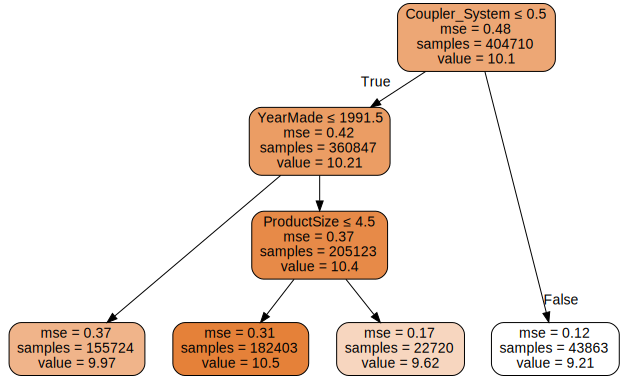

In [36]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

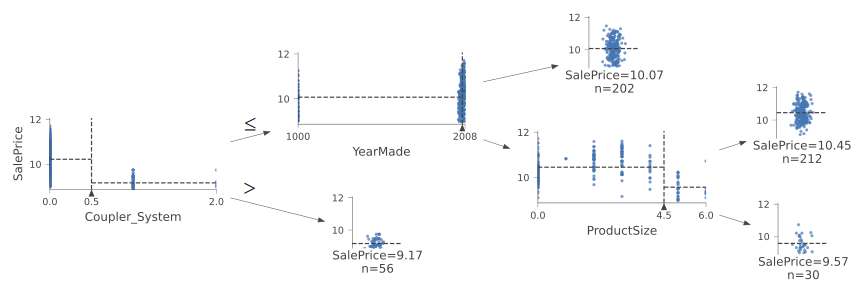

In [37]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

This shows a chart of the distribution of the data for each split point. We can clearly see that there's a problem with our YearMade data: there are bulldozers made in the year 1000, apparently! Presumably this is actually just a missing value code (a value that doesn't otherwise appear in the data and that is used as a placeholder in cases where a value is missing). For modeling purposes, 1000 is fine, but as you can see this outlier makes visualization of the values we are interested in more difficult. So, let's replace it with 1950

In [40]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950


That change makes the split much clearer in the tree visualization, even although it doesn't actually change the result of the model in any significant way. This is a great example of how resilient decision trees are to data issues!

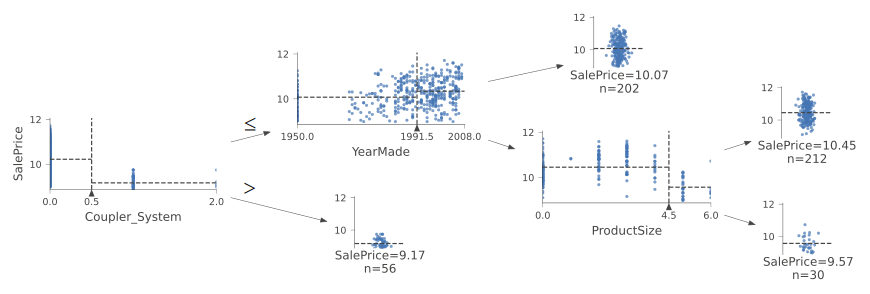

In [41]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Let's now have the decision tree algorithm build a bigger tree. Here, we are not passing in any stopping criteria such as max_leaf_nodes:



In [42]:

m = DecisionTreeRegressor()
m.fit(xs, y);

We'll create a little function to check the root mean squared error of our model (m_rmse), since that's how the competition was judged:



In [43]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [44]:
m_rmse(m, xs, y)

0.0

So, our model is perfect, right? Not so fast... remember we really need to check the validation set, to ensure we're not overfitting:



In [45]:
m_rmse(m, valid_xs, valid_y)

0.334935

it looks like we might be overfitting pretty badly. Here's why:

In [46]:
m.get_n_leaves(), len(xs)


(324560, 404710)

We've got nearly as many leaf nodes as data points! That seems a little over-enthusiastic. Indeed, sklearn's default settings allow it to continue splitting nodes until there is only one item in each leaf node. Let's change the stopping rule to tell sklearn to ensure every leaf node contains at least 25 auction records:

In [47]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248593, 0.323339)

That looks much better. Let's check the number of leaves again:

In [48]:
m.get_n_leaves()

12397


Building a decision tree is a good way to create a model of our data. It is very flexible, since it can clearly handle nonlinear relationships and interactions between variables. But we can see there is a fundamental compromise between how well it generalizes (which we can achieve by creating small trees) and how accurate it is on the training set (which we can achieve by using large trees).

So how do we get the best of both worlds? We'll show you right after we handle an important missing detail: how to handle categorical variables.

# Handling categorical Variables
In the previous chapter, when working with deep learning networks, we dealt with categorical variables by one-hot encoding them and feeding them to an embedding layer. 

In a decision tree, we don't have embeddings layers—so how can these untreated categorical variables do anything useful in a decision tree? For instance, how could something like a product code be used?

The short answer is: it just works! Think about a situation where there is one product code that is far more expensive at auction than any other one. In that case, any binary split will result in that one product code being in some group, and that group will be more expensive than the other group. Therefore, our simple decision tree building algorithm will choose that split. Later during training the algorithm will be able to further split the subgroup that contains the expensive product code, and over time, the tree will home in on that one expensive product.

It is also possible to use one-hot encoding to replace a single categorical variable with multiple one-hot-encoded columns, where each column represents a possible level of the variable. Pandas has a get_dummies method which does just that.

However, there is not really any evidence that such an approach improves the end result. So, we generally avoid it where possible, because it does end up making your dataset harder to work with. 

# Random Forests
Bagging predictors is a method for generating multiple versions of a predictor and using these to get an aggregated predictor. The aggregation averages over the versions... The multiple versions are formed by making bootstrap replicates of the learning set and using these as new learning sets. Tests… show that bagging can give substantial gains in accuracy. The vital element is the instability of the prediction method. If perturbing the learning set can cause significant changes in the predictor constructed, then bagging can improve accuracy.

Here is the procedure that Breiman is proposing:

1. Randomly choose a subset of the rows of your data.
2. Train a model using this subset.
3. Save that model, and then return to step 1 a few times.
4. This will give you a number of trained models. To make a prediction, predict using all of the models, and then take the average of each of those model's predictions.


This procedure is known as "bagging." It is based on a deep and important insight: although each of the models trained on a subset of data will make more errors than a model trained on the full dataset, those errors will not be correlated with each other. Different models will make different errors. The average of those errors, therefore, is: zero! So if we take the average of all of the models' predictions, then we should end up with a prediction that gets closer and closer to the correct answer,

In essence a random forest is a model that averages the predictions of a large number of decision trees, which are generated by randomly varying various parameters that specify what data is used to train the tree and other tree parameters. Bagging is a particular approach to "ensembling," or combining the results of multiple models together.

# Creating a Random Forest
We can create a random forest just like we created a decision tree, except now, we are also specifying parameters that indicate how many trees should be in the forest, how we should subset the data items (the rows), and how we should subset the fields (the columns).

In the following function definition n_estimators defines the number of trees we want, max_samples defines how many rows to sample for training each tree, and max_features defines how many columns to sample at each split point (where 0.5 means "take half the total number of columns"). We can also specify when to stop splitting the tree nodes, effectively limiting the depth of the tree, by including the same min_samples_leaf parameter we used in the last section. Finally, we pass n_jobs=-1 to tell sklearn to use all our CPUs to build the trees in parallel. By creating a little function for this, we can more quickly try different variations in the rest of this chapter:

In [4]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [50]:
m = rf(xs, y);

In [51]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.170966, 0.232699)

One of the most important properties of random forests is that they aren't very sensitive to the hyperparameter choices, such as max_features. You can set n_estimators to as high a number as you have time to train—the more trees you have, the more accurate the model will be.

# Model Interpretation
For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:

1. How confident are we in our predictions using a particular row of data?
2. For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
3. Which columns are the strongest predictors, which can we ignore?
4. Which columns are effectively redundant with each other, for purposes of prediction?
5. How do predictions vary, as we vary these columns?

# Tree Variance for Prediction Confidence
We saw how the model averages the individual tree's predictions to get an overall prediction—that is, an estimate of the value. But how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions across the trees, instead of just the mean. This tells us the relative confidence of predictions. In general, we would want to be more cautious of using the results for rows where trees give very different results (higher standard deviations), compared to cases where they are more consistent (lower standard deviations).

In the earlier section on creating a random forest, we saw how to get predictions over the validation set, using a Python list comprehension to do this for each tree in the forest:

In [53]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [54]:
preds.shape

(40, 7988)


Now we have a prediction for every tree and every auction (40 trees and 7,988 auctions) in the validation set.

Using this we can get the standard deviation of the predictions over all the trees, for each auction:

In [55]:
preds_std = preds.std(0)

Here are the standard deviations for the predictions for the first five auctions—that is, the first five rows of the validation set:



In [56]:
preds_std[:5]

array([0.26069358, 0.10409366, 0.09904178, 0.27184634, 0.13110276])

As you can see, the confidence in the predictions varies widely. For some auctions, there is a low standard deviation because the trees agree. For others it's higher, as the trees don't agree. This is information that would be useful in a production setting; for instance, if you were using this model to decide what items to bid on at auction, a low-confidence prediction might cause you to look more carefully at an item before you made a bid.

# Feature Importance
It's not normally enough just to know that a model can make accurate predictions—we also want to know how it's making predictions. feature importance gives us insight into this. We can get these directly from sklearn's random forest by looking in the feature_importances_ attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

In [57]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

The feature importances for our model show that the first few most important columns have much higher importance scores than the rest, with (not surprisingly) YearMade and ProductSize being at the top of the list:

In [58]:
fi = rf_feat_importance(m, xs)
fi[:10]

cols       imp
57            YearMade  0.173023
6          ProductSize  0.117253
30      Coupler_System  0.117053
7   fiProductClassDesc  0.073112
54             ModelID  0.054777
65         saleElapsed  0.048835
3      fiSecondaryDesc  0.046104
31      Grouser_Tracks  0.041196
12           Enclosure  0.040495
32     Hydraulics_Flow  0.032725

A plot of the feature importances shows the relative importances more clearly:

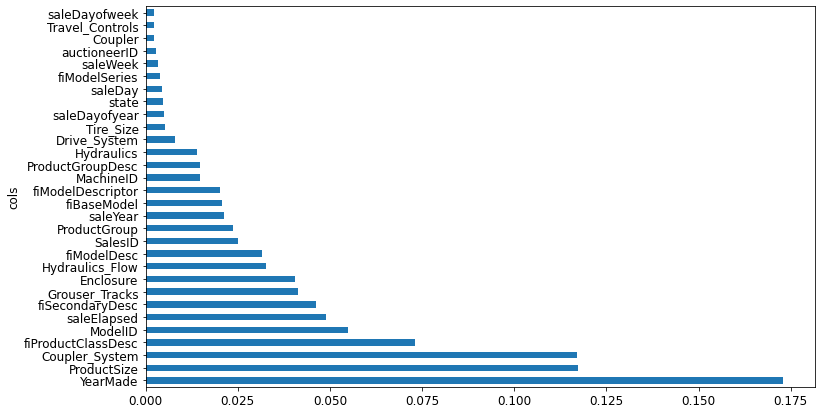

In [59]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

The way these importances are calculated is quite simple yet elegant. The feature importance algorithm loops through each tree, and then recursively explores each branch. At each branch, it looks to see what feature was used for that split, and how much the model improves as a result of that split. The improvement (weighted by the number of rows in that group) is added to the importance score for that feature. This is summed across all branches of all trees, and finally the scores are normalized such that they add to 1.

# Removing Low-Importance Variables
It seems likely that we could use just a subset of the columns by removing the variables of low importance and still get good results. Let's try just keeping those with a feature importance greater than 0.005:

In [60]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

We can retrain our model using just this subset of the columns:



In [61]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [62]:
m = rf(xs_imp, y)

In [63]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.18131, 0.230503)

Our accuracy is about the same, but we have far fewer columns to study:



In [64]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

We've found that generally the first step to improving a model is simplifying it—78 columns was too many for us to study them all in depth! Furthermore, in practice often a simpler, more interpretable model is easier to roll out and maintain.

This also makes our feature importance plot easier to interpret. Let's look at it again:

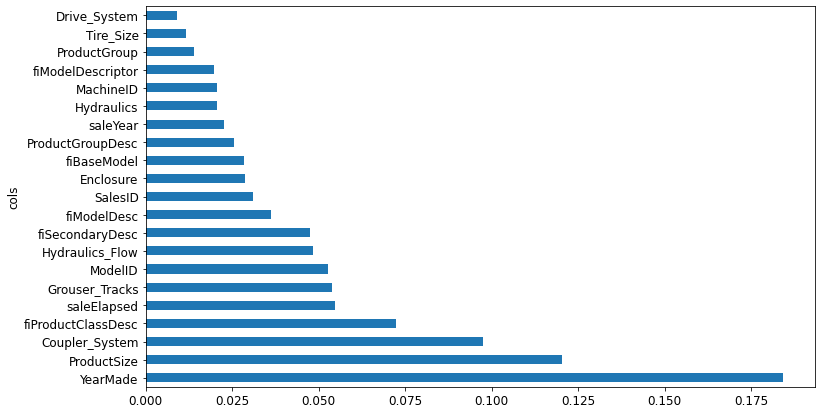

In [65]:
plot_fi(rf_feat_importance(m, xs_imp));

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings: for example, ProductGroup and ProductGroupDesc. Let's try to remove any redundent features.

## Removing Redundant Features

In this chart, the pairs of columns that are most similar are the ones that were merged together early, far from the "root" of the tree at the left. Unsurprisingly, the fields ProductGroup and ProductGroupDesc were merged quite early, as were saleYear and saleElapsed and fiModelDesc and fiBaseModel. These might be so closely correlated they are practically synonyms for each other.

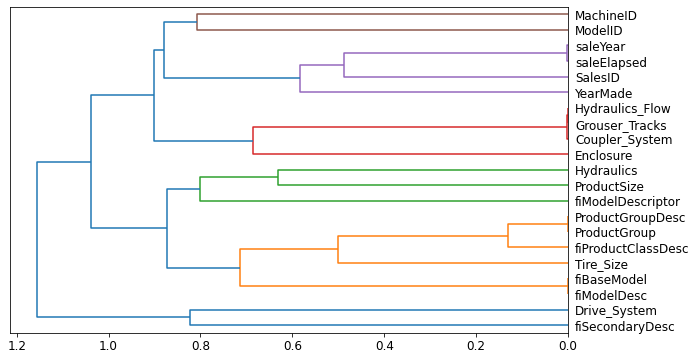

In [66]:
cluster_columns(xs_imp)

Let's try removing some of these closely related features to see if the model can be simplified without impacting the accuracy. First, we create a function that quickly trains a random forest and returns the OOB score, by using a lower max_samples and higher min_samples_leaf. The OOB score is a number returned by sklearn that ranges between 1.0 for a perfect model and 0.0 for a random model. (In statistics it's called R^2, although the details aren't important for this explanation.) We don't need it to be very accurate—we're just going to use it to compare different models, based on removing some of the possibly redundant columns:

In [67]:

def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [68]:
get_oob(xs_imp)

0.8781576734893485

Now we try removing each of our potentially redundant variables, one at a time:

In [69]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8768628311464004,
 'saleElapsed': 0.8722097904682757,
 'ProductGroupDesc': 0.8770087512874477,
 'ProductGroup': 0.8778594920344923,
 'fiModelDesc': 0.8754781084425128,
 'fiBaseModel': 0.8761168180455399,
 'Hydraulics_Flow': 0.8774995916903535,
 'Grouser_Tracks': 0.8775565092698138,
 'Coupler_System': 0.8770165273393064}

Now let's try dropping multiple variables. We'll drop one from each of the tightly aligned pairs we noticed earlier. Let's see what that does:



In [70]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8750482697068109

Looking good! This is really not much worse than the model with all the fields. Let's create DataFrames without these columns, and save them:

In [71]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [72]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)


We can load them back later with:

In [73]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')


Now we can check our RMSE again, to confirm that the accuracy hasn't substantially changed.

In [74]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183251, 0.232259)

By focusing on the most important variables, and removing some redundant ones, we've greatly simplified our model. Now, let's see how those variables affect our predictions using partial dependence plots.

## Partial Dependence
As we've seen, the two most important predictors are ProductSize and YearMade. We'd like to understand the relationship between these predictors and sale price. It's a good idea to first check the count of values per category (provided by the Pandas value_counts method), to see how common each category is:

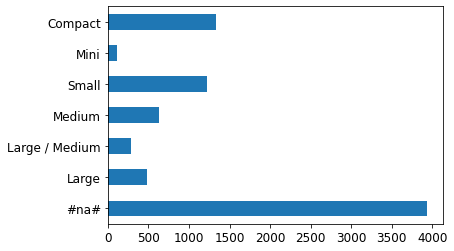

In [75]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

The largest group is #na#, which is the label fastai applies to missing values.

Let's do the same thing for YearMade. Since this is a numeric feature, we'll need to draw a histogram, which groups the year values into a few discrete bins:

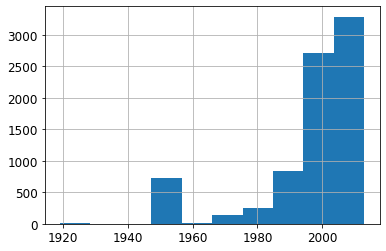

In [76]:
ax = valid_xs_final['YearMade'].hist()

Now we're ready to look at partial dependence plots. Partial dependence plots try to answer the question: if a row varied on nothing other than the feature in question, how would it impact the dependent variable?

For instance, how does YearMade impact sale price, all other things being equal?

To answer this question, we can't just take the average sale price for each YearMade. The problem with that approach is that many other things vary from year to year as well, such as which products are sold, how many products have air-conditioning, inflation, and so forth. So, merely averaging over all the auctions that have the same YearMade would also capture the effect of how every other field also changed along with YearMade and how that overall change affected price.

Instead, what we do is replace every single value in the YearMade column with 1950, and then calculate the predicted sale price for every auction, and take the average over all auctions. Then we do the same for 1951, 1952, and so forth until our final year of 2011. This isolates the effect of only YearMade (even if it does so by averaging over some imagined records where we assign a YearMade value that might never actually exist alongside some other values).

With these averages, we can then plot each of these years on the x-axis, and each of the predictions on the y-axis. This, finally, is a partial dependence plot. Let's take a look:

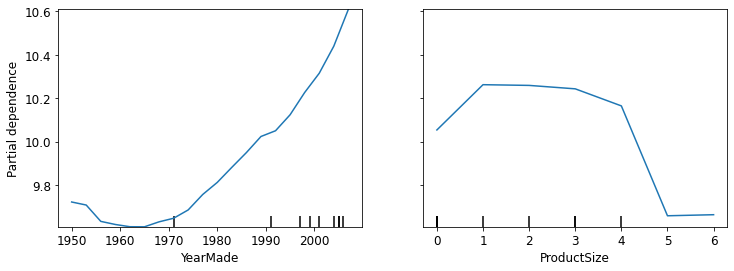

In [77]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

# Tree Interpreter

In [78]:

#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

At the start of this section, we said that we wanted to be able to answer five questions:

1. How confident are we in our predictions using a particular row of data?
2. For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
3. Which columns are the strongest predictors?
4. Which columns are effectively redundant with each other, for purposes of prediction?
5. How do predictions vary, as we vary these columns?


We've handled four of these already; only the second question remains. To answer this question, we need to use the treeinterpreter library. We'll also use the waterfallcharts library to draw the chart of the results.

In [79]:
!pip install treeinterpreter

You should consider upgrading via the 'c:\users\naim cavin\anaconda3\python.exe -m pip install --upgrade pip' command.


In [80]:
!pip install waterfallcharts

You should consider upgrading via the 'c:\users\naim cavin\anaconda3\python.exe -m pip install --upgrade pip' command.



We have already seen how to compute feature importances across the entire random forest. The basic idea was to look at the contribution of each variable to improving the model, at each branch of every tree, and then add up all of these contributions per variable.

We can do exactly the same thing, but for just a single row of data. For instance, let's say we are looking at some particular item at auction. Our model might predict that this item will be very expensive, and we want to know why. So, we take that one row of data and put it through the first decision tree, looking to see what split is used at each point throughout the tree. For each split, we see what the increase or decrease in the addition is, compared to the parent node of the tree. We do this for every tree, and add up the total change in importance by split variable.

In [81]:
row = valid_xs_final.iloc[:5]

We can then pass these to treeinterpreter:



In [82]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)


prediction is simply the prediction that the random forest makes. bias is the prediction based on taking the mean of the dependent variable (i.e., the model that is the root of every tree). contributions is the most interesting bit—it tells us the total change in predicition due to each of the independent variables. Therefore, the sum of contributions plus bias must equal the prediction, for each row. Let's look just at the first row:

In [83]:
prediction[0], bias[0], contributions[0].sum()

(array([9.94708073]), 10.104746057831763, -0.15766532528651994)

The clearest way to display the contributions is with a waterfall plot. This shows how the positive and negative contributions from all the independent variables sum up to create the final prediction, which is the righthand column labeled "net" here:

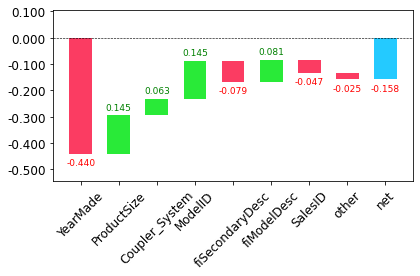

In [84]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

This kind of information is most useful in production, rather than during model development. You can use it to provide useful information to users of your data product about the underlying reasoning behind the predictions.

# Extrapolation and Neural Networks
A problem with random forests, like all machine learning or deep learning algorithms, is that they don't always generalize well to new data. We will see in which situations neural networks generalize better, but first, let's look at the extrapolation problem that random forests have.

In [85]:
#hide
np.random.seed(42)

Let's consider the simple task of making predictions from 40 data points showing a slightly noisy linear relationship:



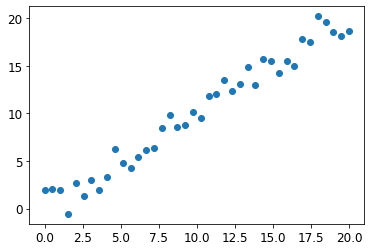

In [86]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);


Although we only have a single independent variable, sklearn expects a matrix of independent variables, not a single vector. So we have to turn our vector into a matrix with one column. In other words, we have to change the shape from [40] to [40,1]. One way to do that is with the unsqueeze method, which adds a new unit axis to a tensor at the requested dimension:

In [87]:

xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

A more flexible approach is to slice an array or tensor with the special value None, which introduces an additional unit axis at that location:



In [88]:
x_lin[:,None].shape

torch.Size([40, 1])

We can now create a random forest for this data. We'll use only the first 30 rows to train the model:



In [89]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

Then we'll test the model on the full dataset. The blue dots are the training data, and the red dots are the predictions:



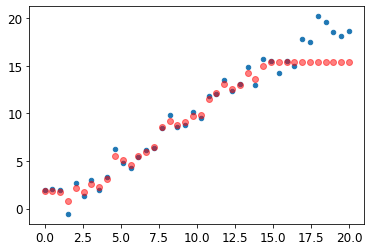

In [90]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

We have a big problem! Our predictions outside of the domain that our training data covered are all too low. Why do you suppose this is?

Remember, a random forest just averages the predictions of a number of trees. And a tree simply predicts the average value of the rows in a leaf. Therefore, a tree and a random forest can never predict values outside of the range of the training data. This is particularly problematic for data where there is a trend over time, such as inflation, and you wish to make predictions for a future time. Your predictions will be systematically too low.

But the problem extends beyond time variables. Random forests are not able to extrapolate outside of the types of data they have seen, in a more general sense. That's why we need to make sure our validation set does not contain out-of-domain data.

Let's get a baseline of the original random forest model's RMSE, then see what the effect is of removing each of these columns in turn:

In [91]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.232087
SalesID 0.229496
saleElapsed 0.235282
MachineID 0.231611


It looks like we should be able to remove SalesID and MachineID without losing any accuracy. Let's check:



In [92]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)


0.229331

Removing these variables has slightly improved the model's accuracy; but more importantly, it should make it more resilient over time, and easier to maintain and understand. We recommend that for all datasets you try building a model where your dependent variable is is_valid, like we did here. It can often uncover subtle domain shift issues that you may otherwise miss.

One thing that might help in our case is to simply avoid using old data. Often, old data shows relationships that just aren't valid any more. Let's try just using the most recent few years of the data:

In [93]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [94]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.177671, 0.229802)

It's a tiny bit better, which shows that you shouldn't always just use your entire dataset; sometimes a subset can be better.

Let's see if using a neural network helps.

# Using a Neural Network
We can use the same approach to build a neural network model. Let's first replicate the steps we took to set up the TabularPandas object:

In [96]:
df_nn = pd.read_csv('TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

We can leverage the work we did to trim unwanted columns in the random forest by using the same set of columns for our neural network:



In [97]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

Categorical columns are handled very differently in neural networks, compared to decision tree approaches.

In [98]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In this case, there's one variable that we absolutely do not want to treat as categorical: the saleElapsed variable. A categorical variable cannot, by definition, extrapolate outside the range of values that it has seen, but we want to be able to predict auction sale prices in the future. Let's verify that cont_cat_split did the correct thing.

In [99]:
cont_nn

['saleElapsed']

Let's take a look at the cardinality of each of the categorical variables that we have chosen so far:



In [100]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Enclosure                6
Hydraulics_Flow          3
fiModelDesc           5059
ProductGroup             6
fiModelDescriptor      140
Hydraulics              12
Drive_System             4
Tire_Size               17
dtype: int64

The fact that there are two variables pertaining to the "model" of the equipment, both with similar very high cardinalities, suggests that they may contain similar, redundant information. Note that we would not necessarily see this when analyzing redundant features, since that relies on similar variables being sorted in the same order (that is, they need to have similarly named levels). Having a column with 5,000 levels means needing 5,000 columns in our embedding matrix, which would be nice to avoid if possible. Let's see what the impact of removing one of these model columns has on the random forest:

In [101]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.176993, 0.230216)

In [102]:
cat_nn.remove('fiModelDescriptor')

We can create our TabularPandas object in the same way as when we created our random forest, with one very important addition: normalization. A random forest does not need any normalization—the tree building procedure cares only about the order of values in a variable, not at all about how they are scaled. But as we have seen, a neural network definitely does care about this. Therefore, we add the Normalize processor when we build our TabularPandas object:

In [103]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

Tabular models and data don't generally require much GPU RAM, so we can use larger batch sizes:

In [104]:
dls = to_nn.dataloaders(1024)

it's a good idea to set y_range for regression models, so let's find the min and max of our dependent variable:

In [105]:
y = to_nn.train.y
y.min(),y.max()

(8.465899467468262, 11.863582611083984)

We can now create the Learner to create this tabular model. As usual, we use the application-specific learner function, to take advantage of its application-customized defaults. We set the loss function to MSE, since that's what this competition uses.

By default, for tabular data fastai creates a neural network with two hidden layers, with 200 and 100 activations, respectively. This works quite well for small datasets, but here we've got quite a large dataset, so we increase the layer sizes to 500 and 250:

In [106]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0002290867705596611)

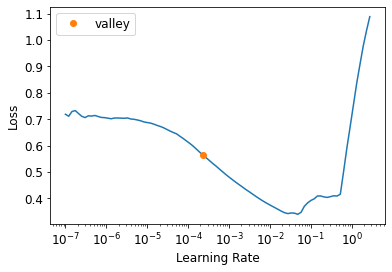

In [107]:
learn.lr_find()

There's no need to use fine_tune, so we'll train with fit_one_cycle for a few epochs and see how it looks:

In [108]:
learn.fit_one_cycle(5, 1e-2)

We can use our r_mse function to compare the result to the random forest result we got earlier:



In [109]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.224602


It's quite a bit better than the random forest (although it took longer to train, and it's fussier about hyperparameter tuning).

Before we move on, let's save our model in case we want to come back to it again later:

In [110]:
learn.save('nn')

Path('models/nn.pth')

# Ensembling
Think back to the original reasoning behind why random forests work so well: each tree has errors, but those errors are not correlated with each other, so the average of those errors should tend towards zero once there are enough trees. Similar reasoning could be used to consider averaging the predictions of models trained using different algorithms.

In our case, we have two very different models, trained using very different algorithms: a random forest, and a neural network. It would be reasonable to expect that the kinds of errors that each one makes would be quite different. Therefore, we might expect that the average of their predictions would be better than either one's individual predictions.

As we saw earlier, a random forest is itself an ensemble. But we can then include a random forest in another ensemble—an ensemble of the random forest and the neural network! While ensembling won't make the difference between a successful and an unsuccessful modeling process, it can certainly add a nice little boost to any models that you have built.

One minor issue we have to be aware of is that our PyTorch model and our sklearn model create data of different types: PyTorch gives us a rank-2 tensor (i.e, a column matrix), whereas NumPy gives us a rank-1 array (a vector). squeeze removes any unit axes from a tensor, and to_np converts it into a NumPy array:

In [111]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [112]:
r_mse(ens_preds,valid_y)

0.222126

This gives us a better result than either model achieved on its own.